# Group 6 Internal Project

 This project is a real estate price predictor which involves GenAI, it's meant to help prospective buyers determine whether they are getting a "good deal"  on a house based on if it's listed price is above or below the price our model predicts for it.

# Exploratory Data Analysis

In [1]:
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!pip3 install scikit-learn
!pip2 install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("usa_real_estate.csv")

# 1. Quick overview
print("Shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics for numeric columns:")
print(df.describe().T)

'pip2' is not recognized as an internal or external command,
operable program or batch file.


Shape: (1048575, 12)

Column types:
brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

Missing values per column:
brokered_by         1038
status                 0
price               1090
bed               310006
bath              324968
acre_lot          178328
street              6776
city                 860
state                  7
zip_code             159
house_size        364886
prev_sold_date    550689
dtype: int64

Summary statistics for numeric columns:
                 count          mean           std  min        25%  \
brokered_by  1047537.0  5.187727e+04  3.039121e+04  0.0   23713.00   
price        1047485.0  4.774979e+05  2.774217e+06  0.0  120000.00   
bed           738569.0  3.309546e+00  1.598269

In [2]:
# 2. Unique values / basic checks for categoricals
print("\nStatus value counts:")
print(df['status'].value_counts(dropna=False).head(20))

print("\nTop 20 cities:")
print(df['city'].value_counts().head(20))

print("\nStates:")
print(df['state'].value_counts())
df.shape


Status value counts:
status
for_sale          1031598
ready_to_build      16977
Name: count, dtype: int64

Top 20 cities:
city
Chicago           12688
New York City      8248
Philadelphia       8206
Miami              6128
Jacksonville       5873
New York           5297
Brooklyn           5123
Naples             4630
Port Charlotte     4299
Cape Coral         4163
Lehigh Acres       4077
Washington         3883
Atlanta            3786
Baltimore          3466
Ocala              3124
Orlando            3080
Dallas             3057
Columbus           2806
Louisville         2743
Tampa              2658
Name: count, dtype: int64

States:
state
Florida                 163840
New York                 71399
North Carolina           58283
Illinois                 53432
Georgia                  52030
Pennsylvania             48885
Texas                    40111
Ohio                     37972
Tennessee                36650
Michigan                 36336
Virginia                 36087
New Jersey

(1048575, 12)

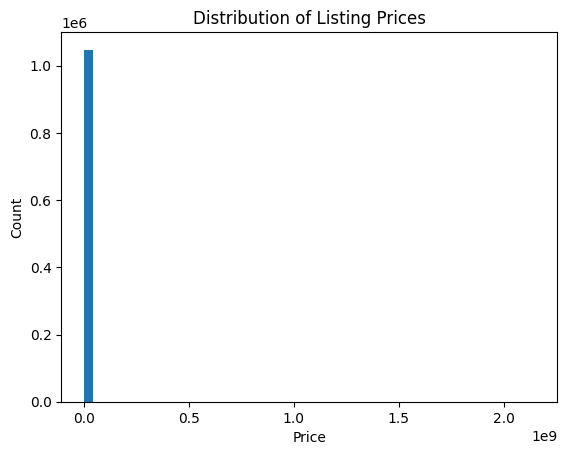

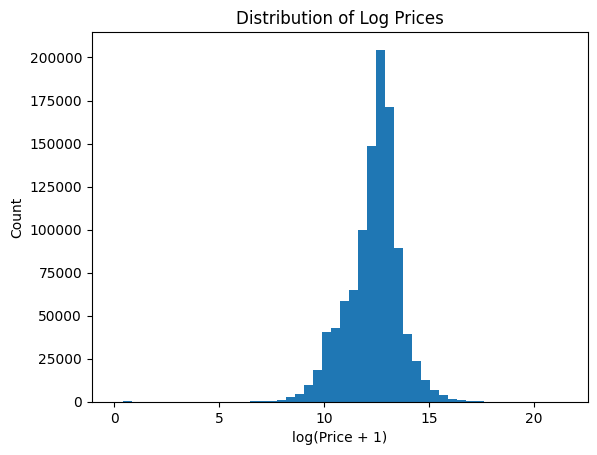

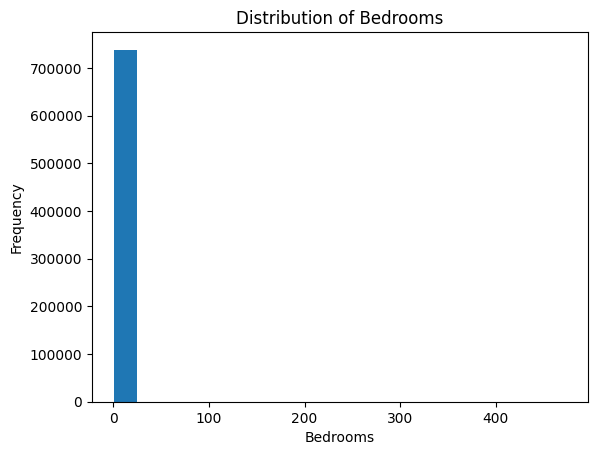

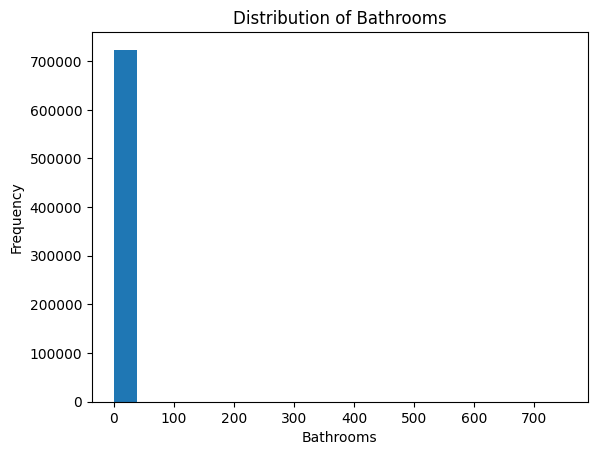

(1048575, 13)

In [3]:
# 3. Simple distributions

# Price distribution (use log to handle skew) (as housing prices are skweded, many cheap houses, few extremely expensive ones)
df['log_price'] = df['price'].apply(lambda x: np.log1p(x) if pd.notna(x) else x)

plt.figure()
df['price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Listing Prices")
plt.show()

plt.figure()
df['log_price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("log(Price + 1)")
plt.ylabel("Count")
plt.title("Distribution of Log Prices")
plt.show()

# Beds and baths
plt.figure()
df['bed'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bedrooms")
plt.title("Distribution of Bedrooms")
plt.show()

plt.figure()
df['bath'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bathrooms")
plt.title("Distribution of Bathrooms")
plt.show()

df.shape

### Price vs House Size (Scatter Plot)

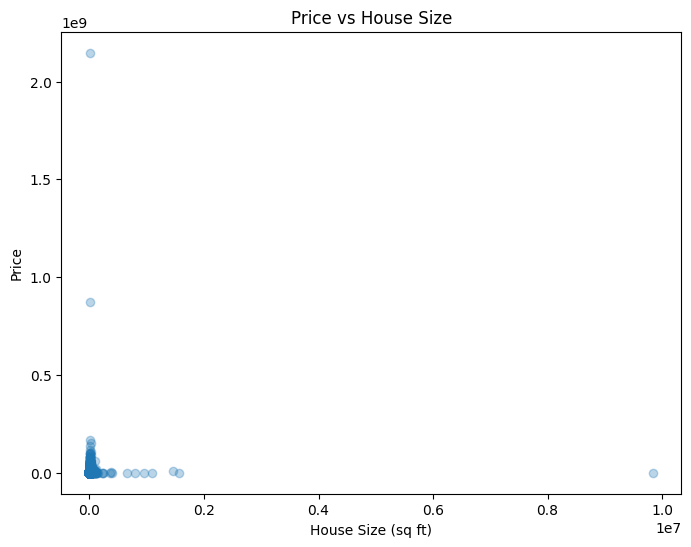

(683107, 2)

In [4]:
# Remove rows where house_size or price is missing
df_clean = df[['price', 'house_size']].dropna()

# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['house_size'], df_clean['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size")
plt.show()

df_clean.shape

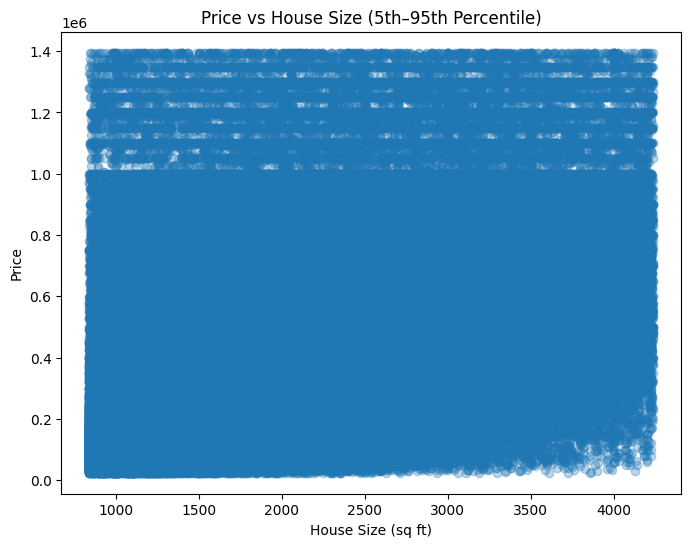

(591200, 13)

In [5]:
# Filter to remove extreme outliers
p_low = df['house_size'].quantile(0.05)
p_high = df['house_size'].quantile(0.95)

df_filtered = df[(df['house_size'] >= p_low) & (df['house_size'] <= p_high)]

# Filter price too
pr_low = df['price'].quantile(0.05)
pr_high = df['price'].quantile(0.95)

df_filtered = df_filtered[(df_filtered['price'] >= pr_low) & (df_filtered['price'] <= pr_high)]

plt.figure(figsize=(8,6))
plt.scatter(df_filtered['house_size'], df_filtered['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (5th–95th Percentile)")
plt.show()

df_filtered.shape


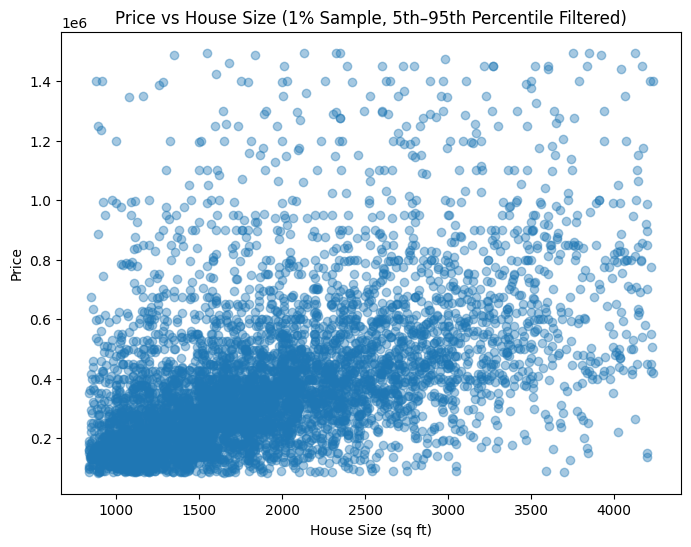

In [6]:
# Apply 5th–95th percentile filtering first
p_low_size = df_clean['house_size'].quantile(0.05)
p_high_size = df_clean['house_size'].quantile(0.95)

p_low_price = df_clean['price'].quantile(0.05)
p_high_price = df_clean['price'].quantile(0.95)

df_filtered = df_clean[
    (df_clean['house_size'] >= p_low_size) &
    (df_clean['house_size'] <= p_high_size) &
    (df_clean['price'] >= p_low_price) &
    (df_clean['price'] <= p_high_price)
]

# Take a 1% random sample
df_sample = df_filtered.sample(frac=0.01, random_state=42)

# Plot sampled scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df_sample['house_size'], df_sample['price'], alpha=0.4)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (1% Sample, 5th–95th Percentile Filtered)")
plt.show()\

# Price does increase as house size increases
# Most homes fall between:
# 1,000–4,000 sq ft
# $150k – $600k
# The relationship is positive but noisy → size matters, but not the only factor (location, quality, etc.)

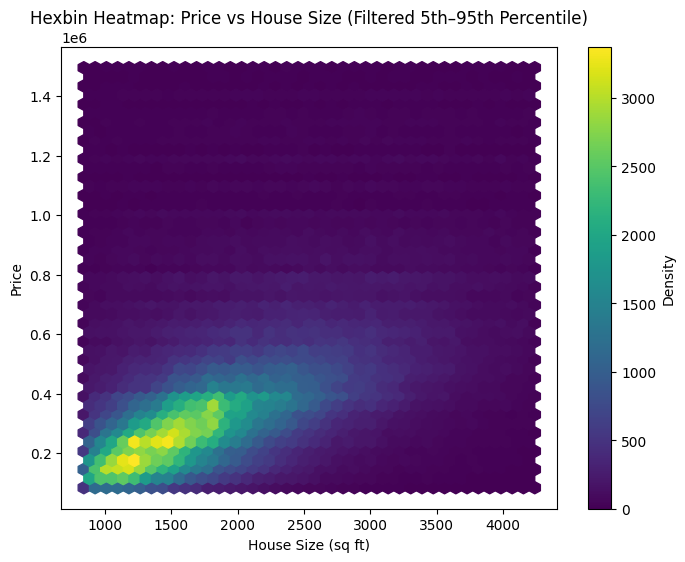

(567852, 2)

In [7]:
# Hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(df_filtered['house_size'], df_filtered['price'], gridsize=40)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Hexbin Heatmap: Price vs House Size (Filtered 5th–95th Percentile)")
plt.colorbar(label="Density")
plt.show()

# The bright yellow/green cluster shows that most homes are around: 1,200–2,000 sq ft & $150,000–$350,000
# The hexbin shape slopes upward, which shows, As house size increases → price increases

df_filtered.shape

state
District of Columbia    700000.0
Massachusetts           585000.0
Montana                 475000.0
Idaho                   454500.0
New Hampshire           439000.0
Delaware                409900.0
New York                399999.0
Virginia                399900.0
Virgin Islands          399000.0
Florida                 395900.0
Name: price, dtype: float64


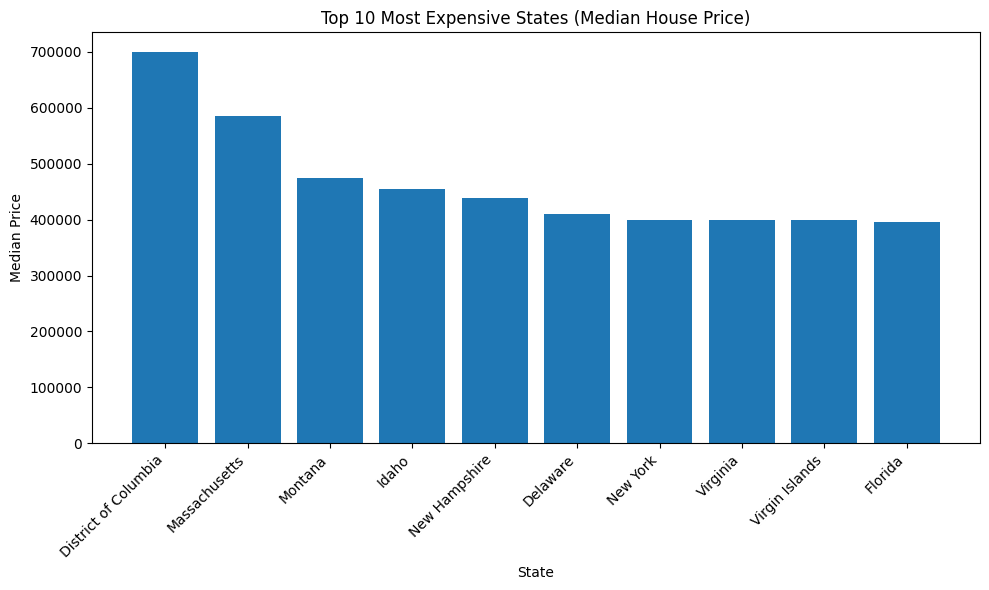

In [8]:
df_state = df[['state', 'price', 'house_size']].dropna()

#    for BOTH price and house_size – this is what keeps CA sane
p_low  = df_state['price'].quantile(0.05)
p_high = df_state['price'].quantile(0.95)
s_low  = df_state['house_size'].quantile(0.05)
s_high = df_state['house_size'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['price'].between(p_low, p_high)) &
    (df_state['house_size'].between(s_low, s_high))
]

state_prices = (
    df_state_filtered
    .groupby('state')['price']
    .median()
    .sort_values(ascending=False)
)

top10 = state_prices.head(10)
print(top10)

# 6. Plot – this should look like your first screenshot
plt.figure(figsize=(10, 6))
plt.bar(top10.index, top10.values)
plt.xlabel("State")
plt.ylabel("Median Price")
plt.title("Top 10 Most Expensive States (Median House Price)")
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')  # remove 1e6 scientific notation
plt.tight_layout()
plt.show()

In [9]:
!pip install plotly
!pip install ipython nbformat>=4.2.0
import plotly.express as px
from IPython.display import HTML

# State name → abbreviation map
state_map = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','District of Columbia':'DC',
    'Florida':'FL','Georgia':'GA','Hawaii':'HI','Idaho':'ID','Illinois':'IL',
    'Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA',
    'Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
    'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV',
    'New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY',
    'North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY',
    'Puerto Rico':'PR','Virgin Islands':'VI'
}

df['state_code'] = df['state'].map(state_map)

# Drop rows with unmapped states
df = df.dropna(subset=['state_code'])

# Keep needed columns
df_state = df[['state_code', 'price', 'house_size']].dropna()

# Percentile filtering
p_low_size = df_state['house_size'].quantile(0.05)
p_high_size = df_state['house_size'].quantile(0.95)
p_low_price = df_state['price'].quantile(0.05)
p_high_price = df_state['price'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['house_size'] >= p_low_size) &
    (df_state['house_size'] <= p_high_size) &
    (df_state['price'] >= p_low_price) &
    (df_state['price'] <= p_high_price)
]

# Median price by state
state_prices = df_state_filtered.groupby('state_code')['price'].median().reset_index()

# Choropleth using state_code
fig = px.choropleth(
    state_prices,
    locations="state_code",
    locationmode="USA-states",
    color="price",
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'price':'Median Price'},
    title="Median House Price by State (Choropleth Map)"
)

fig.show()

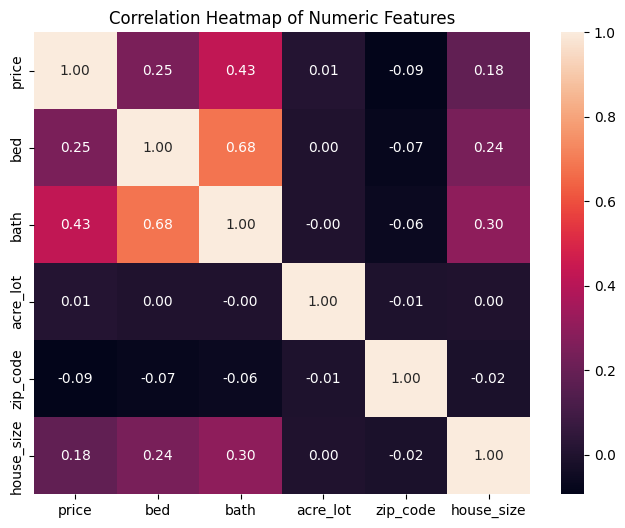

(526588, 6)

In [10]:
import seaborn as sns

# Select numeric columns only
numeric_df = df[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']].dropna()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

numeric_df.shape


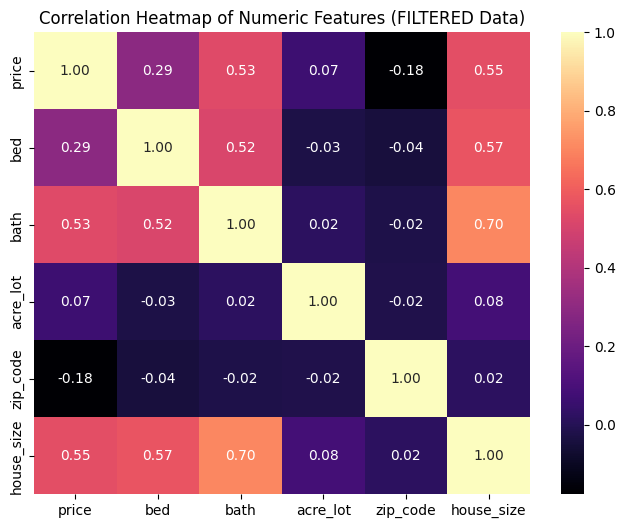

In [11]:
df_mod = df[['price', 'bed', 'bath', 'house_size', 'acre_lot', 'zip_code']].dropna()

# Apply 5th–95th percentile filtering
for col in ['price', 'house_size']:
    low = df_mod[col].quantile(0.05)
    high = df_mod[col].quantile(0.95)
    df_mod = df_mod[(df_mod[col] >= low) & (df_mod[col] <= high)]

df_mod = df_mod[
    df_mod['acre_lot'].between(0.1, 10) &
    df_mod['bed'].between(1, 7) &
    df_mod['bath'].between(1, 7)
]

# Step 3: Create numeric-only dataset
numeric_df = df_mod[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']]

# Step 4: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Heatmap of Numeric Features (FILTERED Data)")
plt.show()

In [12]:
df_sub = df[['price', 'state', 'city']].dropna()

# Apply percentile filtering on price to remove extreme outliers
p_low  = df_sub['price'].quantile(0.05)
p_high = df_sub['price'].quantile(0.95)

df_sub = df_sub[(df_sub['price'] >= p_low) & (df_sub['price'] <= p_high)]

# --- Correlation Ratio Function (η²) ---
def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_codes = categories.codes
    grand_mean = np.mean(measurements)
    ss_between = 0
    for cat in np.unique(cat_codes):
        group = measurements[cat_codes == cat]
        ss_between += len(group) * (np.mean(group) - grand_mean)**2
    ss_total = np.sum((measurements - grand_mean)**2)
    return ss_between / ss_total if ss_total != 0 else 0

# Compute correlation ratios
eta_state = correlation_ratio(df_sub['state'], df_sub['price'])
eta_city = correlation_ratio(df_sub['city'], df_sub['price'])

eta_state, eta_city



(np.float64(0.06975369590776247), np.float64(0.27900389069043324))

In [13]:
# # Step 1: Target encode (like you did for training)
# from category_encoders import TargetEncoder

# df_sub = df[['price', 'state', 'city']].dropna()

# # Apply percentile filtering
# p_low = df_sub['price'].quantile(0.05)
# p_high = df_sub['price'].quantile(0.95)
# df_sub = df_sub[(df_sub['price'] >= p_low) & (df_sub['price'] <= p_high)]

# # Step 2: Target encode state and city
# city_encoder = TargetEncoder(cols=['city'], smoothing=1.0)
# state_encoder = TargetEncoder(cols=['state'], smoothing=1.0)

# df_sub['city_encoded'] = city_encoder.fit_transform(df_sub['city'], df_sub['price'])['city']
# df_sub['state_encoded'] = state_encoder.fit_transform(df_sub['state'], df_sub['price'])['state']

# # Step 3: NOW use Pearson correlation
# pearson_city = df_sub['city_encoded'].corr(df_sub['price'])
# pearson_state = df_sub['state_encoded'].corr(df_sub['price'])

# print("="*60)
# print("PEARSON CORRELATION (After Target Encoding)")
# print("="*60)
# print(f"City encoded  → Price: {pearson_city:.4f}")
# print(f"State encoded → Price: {pearson_state:.4f}")

# # Compare with η²
# eta_state = correlation_ratio(df_sub['state'], df_sub['price'])
# eta_city = correlation_ratio(df_sub['city'], df_sub['price'])

# print("\n" + "="*60)
# print("CORRELATION RATIO η² (Original Categories)")
# print("="*60)
# print(f"City  → Price: {eta_city:.4f}")
# print(f"State → Price: {eta_state:.4f}")

# Data Cleaning and Feature Engineering

This section prepares some of the columns and datatypes of the data for training our price prediction model.

In [14]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states in the dataset: {len(df['state'].unique())}')
print(f'no. of cities in the dataset: {len(df['city'].unique())}')

no. of states in the dataset: 46
no. of cities in the dataset: 15972


In [15]:
# removing null values for important columns
no_null = ['price', 'house_size', 'bed', 'bath', 'acre_lot', 'state', 'city']
new_df = df.dropna(subset = no_null)

# Removing street, zip code, broker-id, status and prev sold date columns as they are not relevant to the model and may reduce accuracy in price prediction.
new_df = new_df.drop(['brokered_by', 'status', 'street', 'zip_code', 'prev_sold_date', 'log_price', 'state_code'], axis = 1)
new_df.shape

# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values: {len(new_df['city'].unique())}')


no. of states left in the dataset post dropping null values: 46
no. of cities left in the dataset post dropping null values: 13526


In [16]:
# Data Cleaning
for cols in new_df.columns:
    if cols == "price" or cols == "house_size":
        low = new_df[cols].quantile(0.05)
        high = new_df[cols].quantile(0.95)
        new_df = new_df[(new_df[cols] >= low) & (new_df[cols] <= high)]
    elif cols == "bed" or cols == "bath" or cols == "acre_lot":
        low = new_df[cols].quantile(0.01)
        high = new_df[cols].quantile(0.99)
        new_df = new_df[(new_df[cols] >= low) & (new_df[cols] <= high)]
    else:
        continue

new_df.shape

(415351, 7)

In [17]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values and removing outliers: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values and removing outliers: {len(new_df['city'].unique())}')

no. of states left in the dataset post dropping null values and removing outliers: 45
no. of cities left in the dataset post dropping null values and removing outliers: 12439


In [18]:
# Changing the name  of the column to lot_size for clarity and removing leftover outliers
new_df = new_df.rename(columns={'acre_lot' : 'lot_size'})
new_df['lot_size'] = new_df['lot_size'] * 43560
new_df

,price,bed,bath,lot_size,city,state,house_size
1,80000.0,4.0,2.0,3484.8,Adjuntas,Puerto Rico,1527.0
3,145000.0,4.0,2.0,4356.0,Ponce,Puerto Rico,1800.0
5,179000.0,4.0,3.0,20037.6,San Sebastian,Puerto Rico,2520.0
8,100000.0,2.0,1.0,3920.4,Ponce,Puerto Rico,1092.0
10,89000.0,3.0,2.0,583268.4,Isabela,Puerto Rico,1106.0
...,...,...,...,...,...,...,...
1048568,508620.0,4.0,3.0,16988.4,Harker Heights,Texas,2595.0
1048569,523171.0,4.0,3.0,17424.0,Harker Heights,Texas,2629.0
1048570,467847.0,5.0,4.0,8276.4,Harker Heights,Texas,3499.0
1048571,345249.0,5.0,3.0,8276.4,Harker Heights,Texas,2572.0


In [19]:
# Dropping null values
new_df = new_df.dropna()
new_df.describe()

,price,bed,bath,lot_size,house_size
count,4.153510e+05,415351.000000,415351.000000,4.153510e+05,415351.000000
mean,3.745055e+05,3.360011,2.436014,4.175757e+04,1967.326021
std,2.184053e+05,0.832941,0.840447,1.184780e+05,660.966789
min,8.000000e+04,1.000000,1.000000,8.712000e+02,960.000000
25%,2.200000e+05,3.000000,2.000000,6.534000e+03,1447.000000
50%,3.250000e+05,3.000000,2.000000,1.089000e+04,1844.000000
75%,4.690550e+05,4.000000,3.000000,2.265120e+04,2397.000000
max,1.385000e+06,7.000000,5.000000,1.478426e+06,3768.000000


In [20]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values: {len(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values: {len(new_df['city'].unique())}')

no. of states left in the dataset post dropping null values: 45
no. of cities left in the dataset post dropping null values: 12439


# Model Selection & Training

In this section we test two models (Gradient Boost and XGBoost) for accuracy and train our dataset on the most accurate one.

In [21]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from category_encoders import TargetEncoder
import pickle

In [22]:
# Splitting data into train and test
# Features
X = new_df[['house_size', 'bed', 'bath', 'city', 'state', 'lot_size']]

# Target
y = new_df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# Reset indices to align with sequential integers (0, 1, 2, ...)
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

X_train.shape, X_test.shape
y_train.shape, y_test.shape


((332280,), (83071,))

In [30]:
# --- TARGET ENCODING SETUP ---

target_column_city = ['city']
target_column_state = ['state']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# X_encoded will hold the training data with encoded features
X_encoded = X_train_reset.copy()
city_encoder = TargetEncoder(cols=target_column_city, smoothing=1.0)
state_encoder = TargetEncoder(cols=target_column_state, smoothing=1.0)

# --- TARGET ENCODING WITH K-FOLD CROSS-VALIDATION ---

# City Encoding Loop
for train_index, val_index in kf.split(X_train_reset):
    X_train_fold = X_train_reset.loc[train_index]
    y_train_fold = y_train_reset.loc[train_index]
    X_val_fold = X_train_reset.loc[val_index]

    city_encoder.fit(X_train_fold, y_train_fold)
    X_encoded.loc[val_index, 'city_encoded'] = city_encoder.transform(X_val_fold)[target_column_city].iloc[:, 0]

# State Encoding Loop
for train_index, val_index in kf.split(X_train_reset):
    X_train_fold = X_train_reset.loc[train_index]
    y_train_fold = y_train_reset.loc[train_index]
    X_val_fold = X_train_reset.loc[val_index]

    state_encoder.fit(X_train_fold, y_train_fold)
    X_encoded.loc[val_index, 'state_encoded'] = state_encoder.transform(X_val_fold)[target_column_state].iloc[:, 0]

# --- FINAL ENCODER FIT ON ALL TRAINING DATA ---

# These encoders will be used for test set transformation and future predictions
final_city_encoder = TargetEncoder(cols=target_column_city, smoothing=1.0)
final_city_encoder.fit(X_train_reset, y_train_reset)

final_state_encoder = TargetEncoder(cols=target_column_state, smoothing=1.0)
final_state_encoder.fit(X_train_reset, y_train_reset)

# --- PREPARE FINAL TRAINING FEATURES ---

X_train_final = X_encoded.drop(columns=['city', 'state'])

# --- PREPARE FINAL TEST FEATURES ---

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop = True)

# Apply the final fitted encoders to test set
# Important: Transform the original data for both encoders BEFORE adding any new columns
city_encoded = final_city_encoder.transform(X_test_reset)[target_column_city].iloc[:, 0]
state_encoded = final_state_encoder.transform(X_test_reset)[target_column_state].iloc[:, 0]

# Now add both encoded columns to the dataframe
X_test_reset['city_encoded'] = city_encoded
X_test_reset['state_encoded'] = state_encoded

# Create the final clean test feature set
X_test_final = X_test_reset.drop(columns=['city', 'state'])

# --- SAVE ENCODERS FOR FUTURE USE ---

with open('final_city_encoder.pkl', 'wb') as file:
    pickle.dump(final_city_encoder, file)
with open('final_state_encoder.pkl', 'wb') as file:
    pickle.dump(final_state_encoder, file)

In [31]:
# Find the actual highest city_encoded value
city_encoding_map = X_train_reset[['city']].copy()
city_encoding_map['city_encoded'] = X_encoded['city_encoded']

# Get unique cities with their encoded values
city_summary = city_encoding_map.groupby('city')['city_encoded'].mean().sort_values(ascending=False)

print("="*60)
print("TOP 20 MOST EXPENSIVE CITIES (Highest Encoded Values)")
print("="*60)
for i, (city, value) in enumerate(city_summary.head(20).items(), 1):
    print(f"{i:2d}. {city:30s} ${value:,.2f}")

print("\n" + "="*60)
print("BOTTOM 20 CHEAPEST CITIES (Lowest Encoded Values)")
print("="*60)
for i, (city, value) in enumerate(city_summary.tail(20).items(), 1):
    print(f"{i:2d}. {city:30s} ${value:,.2f}")


# Find the actual highest city_encoded value
state_encoding_map = X_train_reset[['state']].copy()
state_encoding_map['state_encoded'] = X_encoded['state_encoded']

# Get unique cities with their encoded values
state_summary = state_encoding_map.groupby('state')['state_encoded'].mean().sort_values(ascending=False)

print("="*60)
print("TOP 20 MOST EXPENSIVE STATES (Highest Encoded Values)")
print("="*60)
for i, (state, value) in enumerate(state_summary.head(20).items(), 1):
    print(f"{i:2d}. {state:30s} ${value:,.2f}")

print("\n" + "="*60)
print("BOTTOM 20 CHEAPEST STATES (Lowest Encoded Values)")
print("="*60)
for i, (state, value) in enumerate(state_summary.tail(20).items(), 1):
    print(f"{i:2d}. {state:30s} ${value:,.2f}")

TOP 20 MOST EXPENSIVE CITIES (Highest Encoded Values)
 1. Key West                       $1,020,173.48
 2. Bethesda                       $1,007,492.86
 3. Madeira Beach                  $999,930.08
 4. Palmetto Bay                   $991,842.44
 5. New York City                  $968,012.88
 6. Bayside                        $950,013.30
 7. Coral Gables                   $946,821.89
 8. Parkland                       $929,192.29
 9. Potomac                        $866,226.36
10. Indialantic                    $862,454.41
11. Pigeon Forge                   $858,690.02
12. Falls Church                   $854,459.17
13. Miramar Beach                  $842,687.11
14. Doral                          $839,470.23
15. Key Largo                      $831,152.06
16. New Hyde Park                  $830,547.07
17. Inlet Beach                    $825,812.72
18. Ocean City                     $819,061.51
19. Somerville                     $816,262.02
20. Lakewood Ranch                 $811,917.95

B

In [32]:
# feature engineering with correlation-based weights
# calculate correlations
corr = X_train_final.corrwith(y_train_reset).abs()

print("Feature correlations with price:")
print('-'*50)
print(corr.sort_values(ascending = False))
print()

weights = {}
# applying weights based on correlation, from 1 to 1.2
max_corr = corr.max()
for col in X_train_final.columns:
    if col == "house_size" or col=="bath" or col=="bed":
        weight = 0.2*(corr[col] / max_corr)
        weights[col] = weight
        X_train_final[col] *= (1 + weight)
        X_test_final[col]  *= (1 + weight)

print("Applied weights for each feature:")
for col, w in weights.items():
    print(f"{col}: {w:.4f}")

# adding interactions between cols
X_train_final['size_bath'] = X_train_final['house_size'] * X_train_final['bath']
# X_train_final['size_city'] = X_train_final['house_size'] * X_train_final['city_encoded']
X_train_final['size_bed'] = X_train_final['house_size'] * X_train_final['bed']

X_test_final['size_bath'] = X_test_final['house_size'] * X_test_final['bath']
# X_test_final['size_city'] = X_test_final['house_size'] * X_test_final['city_encoded']
X_test_final['size_bed'] = X_test_final['house_size'] * X_test_final['bed']

print("Features have been created successfully and are being applied to the datasets.")

Feature correlations with price:
--------------------------------------------------
house_size       0.517395
bath             0.508290
city_encoded     0.505512
state_encoded    0.337354
bed              0.262511
lot_size         0.094404
dtype: float64

Applied weights for each feature:
house_size: 0.2000
bed: 0.1015
bath: 0.1965
Features have been created successfully and are being applied to the datasets.


In [33]:
X_train_final

,house_size,bed,bath,lot_size,city_encoded,state_encoded,size_bath,size_bed
0,2726.4,5.507371,3.589441,14810.4,302833.382609,368382.452978,9786.251492,15015.297376
1,2419.2,5.507371,2.392961,51836.4,403558.972826,405361.731829,5789.050178,13323.432883
2,2973.6,3.304423,3.589441,5227.2,416804.677621,462727.599308,10673.561266,9826.031751
3,1486.8,3.304423,2.392961,16117.2,276605.919355,273837.926753,3557.853755,4913.015875
4,2071.2,4.405897,2.392961,22651.2,248742.297873,283264.514779,4956.299905,9125.494109
...,...,...,...,...,...,...,...,...
332275,2208.0,4.405897,3.589441,3920.4,170934.833333,259140.367300,7925.485363,9728.220835
332276,2378.4,4.405897,2.392961,14810.4,374459.015525,327658.531494,5691.417388,10478.985704
332277,4164.0,5.507371,4.785921,88426.8,302418.210131,389973.008996,19928.575515,22932.694495
332278,2382.0,3.304423,2.392961,37897.2,402028.870130,370150.053804,5700.032046,7871.135200


In [34]:
# checking for any data leakage or leftover outliers by comparing train and test datasets
print("Target Distribution Comparison:")
print('-'*50)
print(f"Train target mean: {y_train_reset.mean():,.2f}")
print(f"Test target mean:  {y_test_reset.mean():,.2f}")
print(f"Train target std:  {y_train_reset.std():,.2f}")
print(f"Test target std:   {y_test_reset.std():,.2f}")
print(f"Train target min:  {y_train_reset.min():,.2f}")
print(f"Train target max:  {y_train_reset.max():,.2f}")
print(f"Test target min:   {y_test_reset.min():,.2f}")
print(f"Test target max:   {y_test_reset.max():,.2f}")

# checking baselines as basis to check model's performance
baseline_pred = np.full(len(y_test_reset), y_train_reset.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test_reset, baseline_pred))
baseline_mae = mean_absolute_error(y_test_reset, baseline_pred)
print("\nBaseline Model (Mean):")
print('-'*50)
print(f"Baseline RMSE: {baseline_rmse:,.2f}")
print(f"Baseline MAE:  {baseline_mae:,.2f}")

# Feature statistics comparison
print("\nComparison per features:")
print('-'*50)
for col in X_train_final.columns:  
    print(f"{col}:")
    print(f"Train mean: {X_train_final[col].mean():.4f}  Test mean: {X_test_final[col].mean():.4f}")
    print(f"Train std:  {X_train_final[col].std():.4f}  Test std:  {X_test_final[col].std():.4f}")
print()
print("Columns in X_train_final:")
print(X_train_final.columns.tolist())

Target Distribution Comparison:
--------------------------------------------------
Train target mean: 374,265.13
Test target mean:  375,466.95
Train target std:  218,144.56
Test target std:   219,443.65
Train target min:  80,000.00
Train target max:  1,385,000.00
Test target min:   80,000.00
Test target max:   1,385,000.00

Baseline Model (Mean):
--------------------------------------------------
Baseline RMSE: 219,445.62
Baseline MAE:  164,051.63

Comparison per features:
--------------------------------------------------
house_size:
Train mean: 2360.9557  Test mean: 2360.1334
Train std:  793.2274  Test std:  792.8954
bed:
Train mean: 3.7008  Test mean: 3.7015
Train std:  0.9171  Test std:  0.9190
bath:
Train mean: 2.9144  Test mean: 2.9156
Train std:  1.0055  Test std:  1.0060
lot_size:
Train mean: 41686.4166  Test mean: 42042.1775
Train std:  118233.9876  Test std:  119449.4980
city_encoded:
Train mean: 377564.4829  Test mean: 377662.8513
Train std:  111282.4255  Test std:  114555.2

### Hyperparameter Tuning and Model Training

In [ ]:
# models = {
#     'GradientBoosting': GradientBoostingRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
# }

# param_grid = {
#     'GradientBoosting': {
#         'model__n_estimators': [150, 200, 250],
#         'model__learning_rate': [0.05],              
#         'model__max_depth': [3, 4, 5],                     
#         'model__min_samples_split': [15, 25],    
#         'model__min_samples_leaf': [10, 20],
#     },
#     'XGBoost': {
#         'model__n_estimators': [200, 250, 350],
#         'model__learning_rate': [0.05],
#         'model__max_depth': [3,4,5],                 
#         'model__min_child_weight': [30, 50, 80],
#         'model__gamma': [0.5, 2],
#     }
# }

In [36]:
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse', tree_method='hist'),
}

param_grid = {
    'GradientBoosting': {
        'model__n_estimators': [250],
        'model__learning_rate': [0.05],              
        'model__max_depth': [5],                     
        'model__min_samples_split': [25],    
        'model__min_samples_leaf': [10],
    },
    'XGBoost': {
        'model__n_estimators': [350],
        'model__learning_rate': [0.05],
        'model__max_depth': [5],                  
        'model__min_child_weight': [50],
        'model__gamma': [0.5],
    }
}

In [37]:
tuned_metrics = {}
tuned_details = {}
best_models = {}
best_params = {}

# start model training and hyperparameter tuning
for name, model in models.items():
    print(f"Tuning {name}...\n")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid[name],
        cv=3,
        scoring=['neg_mean_squared_error','neg_mean_absolute_error'],
        refit='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        error_score='raise',
    )
    
    # train model using grid search, with training dataset
    gs.fit(X_train_final, y_train_reset)
    best_pipeline = gs.best_estimator_
    best_models[name] = best_pipeline
    best_params[name] = gs.best_params_ 
    
    # evaluate performance of each hyperparameter combination, done to facilitate comparison between train and test scores
    results = gs.cv_results_
    params = results['params']
    train_rmse = (-results['mean_train_neg_mean_squared_error']) ** 0.5
    train_mae = (-results['mean_train_neg_mean_absolute_error'])
    
    test_rmse = []
    test_mae = []
    for i, p in enumerate(params):
        # setting pipeline to the specific hyperparameter combination
        pipeline.set_params(**p)
        pipeline.fit(X_train_final, y_train_reset)
        test_preds = pipeline.predict(X_test_final)

        # evaluate model prediction performance on test set
        rmse = root_mean_squared_error(y_test_reset, test_preds)
        mae = mean_absolute_error(y_test_reset, test_preds)
        r2 = r2_score(y_test_reset, test_preds)
        test_rmse.append(rmse)
        test_mae.append(mae)
        
        print(f"Combination {i+1}: {p}")
        print(f"Train RMSE = {train_rmse[i]:,.2f}   Train MAE = {train_mae[i]:,.2f}")
        print(f"Test RMSE = {rmse:,.2f}   Test MAE = {mae:,.2f}")
        print(f"Test r2 = {r2:,.2f}")
        print("-"*50)
    
    # Store detailed results in dataframe
    df_metrics = pd.DataFrame({
        "params": params,
        "train_rmse": train_rmse,    
        "test_rmse": test_rmse,    
    })
    tuned_details[name] = df_metrics
    
    # finding the index of the best (lowest) test RMSE
    best_idx = np.argmin(test_rmse)
    best_rmse = test_rmse[best_idx]
    best_mae = test_mae[best_idx]
    tuned_metrics[name] = {'rmse': best_rmse, 'mae': best_mae}

print("\n\nBest test results:")
for name, metrics in tuned_metrics.items():
    print(f"{name} - Best params: {best_params[name]}")
    print(f"{name} - Test RMSE: {metrics['rmse']:.4f}")   
    print(f"{name} - Test MAE: {metrics['mae']:.4f}\n")    
    print('-'*50)

Tuning GradientBoosting...

Combination 1: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 25, 'model__n_estimators': 250}
Train RMSE = 133,985.40   Train MAE = 91,076.44
Test RMSE = 137,216.99   Test MAE = 92,401.69
Test r2 = 0.61
--------------------------------------------------
Tuning XGBoost...

Combination 1: {'model__gamma': 0.5, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 50, 'model__n_estimators': 350}
Train RMSE = 133,216.20   Train MAE = 90,519.67
Test RMSE = 135,991.88   Test MAE = 91,700.23
Test r2 = 0.62
--------------------------------------------------


Best test results:
GradientBoosting - Best params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 25, 'model__n_estimators': 250}
GradientBoosting - Test RMSE: 137216.9893
GradientBoosting - Test MAE: 92401.6948

-------------------------------------------

RMSE results for GradientBoosting
--------------------------------------------------
Best combination #1: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 25, 'model__n_estimators': 250}
Train RMSE: 133,985.40  Test RMSE: 137,216.99
Overfit Ratio: 1.02x, current model is a good fit

Plotting boosting iterations for the BEST GradientBoosting model...


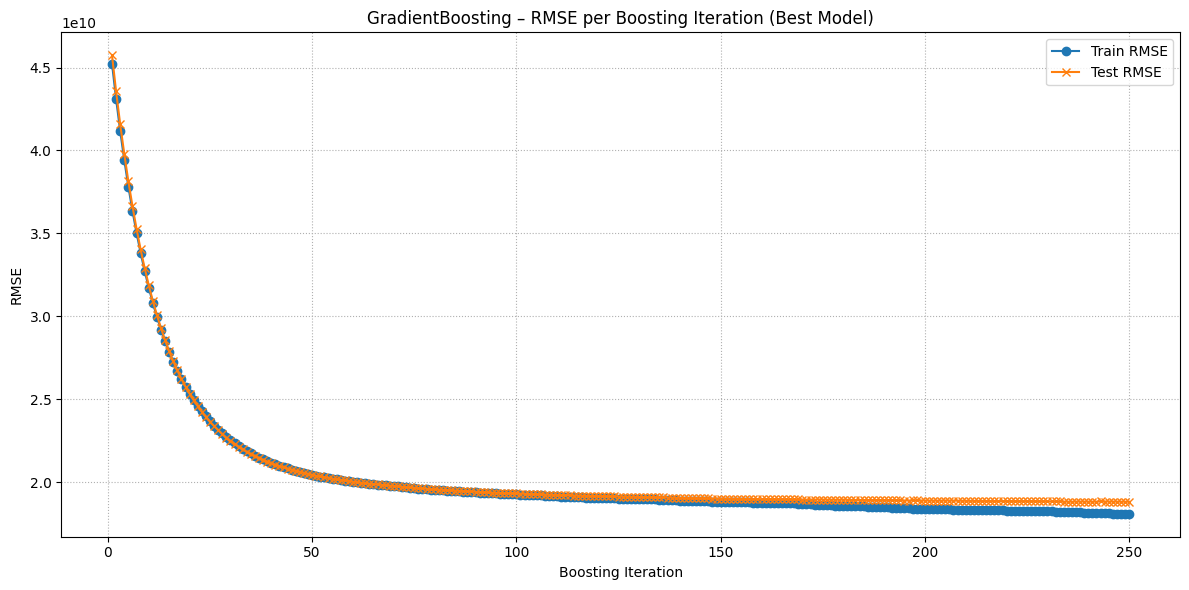

RMSE results for XGBoost
--------------------------------------------------
Best combination #1: {'model__gamma': 0.5, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 50, 'model__n_estimators': 350}
Train RMSE: 133,216.20  Test RMSE: 135,991.88
Overfit Ratio: 1.02x, current model is a good fit

Plotting boosting iterations for the BEST XGBoost model...


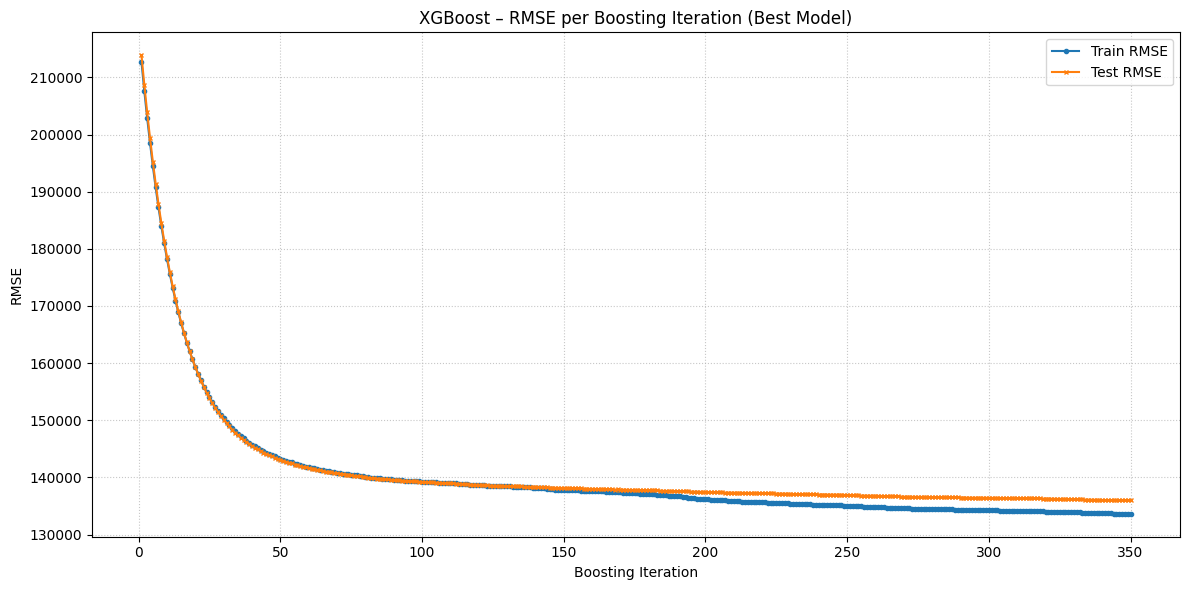

In [38]:
from sklearn.metrics import mean_squared_error

# visualizing model performance

# checking model performance
for name, details in tuned_details.items():
    # extract arrays
    train_rmse = np.array(details['train_rmse'])
    test_rmse = np.array(details['test_rmse'])
    params = details['params']

    # best combination
    best_idx = test_rmse.argmin()
    overfit_ratio = test_rmse[best_idx] / train_rmse[best_idx]
    
    print(f"RMSE results for {name}")
    print('-'*50)
    print(f"Best combination #{best_idx + 1}: {params[best_idx]}")
    print(f"Train RMSE: {train_rmse[best_idx]:,.2f}  Test RMSE: {test_rmse[best_idx]:,.2f}")
    print(f"Overfit Ratio: {overfit_ratio:.2f}x", end=", ")

    if overfit_ratio >= 1 and overfit_ratio < 1.2:
        print("current model is a good fit")
    elif overfit_ratio >=1 and test_rmse[best_idx] < baseline_rmse:
        print("Current model is underfitting")
    elif overfit_ratio < 1.5:
        print("Current model is slightly overfitting")
    else:
        print("Current model is overfitting")

    #----------------
    
    if name == "GradientBoosting":
        print("\nPlotting boosting iterations for the BEST GradientBoosting model...")

        # extract best pipeline
        best_gb = best_models['GradientBoosting']
        gb_model = best_gb.named_steps['model']
        scaler = best_gb.named_steps['scaler']

        # scale data
        X_train_scaled = scaler.transform(X_train_final)
        X_test_scaled  = scaler.transform(X_test_final)

        gb_train_rmse = []
        gb_test_rmse = []

        # compute staged RMSE
        for y_pred_train in gb_model.staged_predict(X_train_scaled):
            gb_train_rmse.append(
                mean_squared_error(y_train_reset, y_pred_train)
            )
        for y_pred_test in gb_model.staged_predict(X_test_scaled):
            gb_test_rmse.append(
                mean_squared_error(y_test_reset, y_pred_test)
            )

        iterations = np.arange(1, len(gb_train_rmse) + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(iterations, gb_train_rmse, marker='o', label='Train RMSE')
        plt.plot(iterations, gb_test_rmse, marker='x', label='Test RMSE')

        plt.title("GradientBoosting – RMSE per Boosting Iteration (Best Model)")
        plt.xlabel("Boosting Iteration")
        plt.ylabel("RMSE")
        plt.grid(True, linestyle=':')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    else:
        print("\nPlotting boosting iterations for the BEST XGBoost model...")

        # extract best pipeline
        best_gb = best_models['XGBoost']
        gb_model = best_gb.named_steps['model']
        scaler = best_gb.named_steps['scaler']

        # scale data
        X_train_scaled = scaler.transform(X_train_final)
        X_test_scaled  = scaler.transform(X_test_final)

        gb_train_rmse = []
        gb_test_rmse = []

        # Get the number of boosting rounds (trees) in the model
        n_estimators = gb_model.n_estimators

        # Compute RMSE for each iteration
        for i in range(1, n_estimators + 1):
            # Predict using only the first i trees
            y_pred_train = gb_model.predict(X_train_scaled, iteration_range=(0, i))
            y_pred_test = gb_model.predict(X_test_scaled, iteration_range=(0, i))
            
            gb_train_rmse.append(np.sqrt(mean_squared_error(y_train_reset, y_pred_train)))
            gb_test_rmse.append(np.sqrt(mean_squared_error(y_test_reset, y_pred_test)))

        iterations = np.arange(1, len(gb_train_rmse) + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(iterations, gb_train_rmse, marker='o', markersize=3, label='Train RMSE')
        plt.plot(iterations, gb_test_rmse, marker='x', markersize=3, label='Test RMSE')

        plt.title("XGBoost – RMSE per Boosting Iteration (Best Model)")
        plt.xlabel("Boosting Iteration")
        plt.ylabel("RMSE")
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    #----------------

    # # plotting line graph for all hyperparameter combinations
    # plt.figure(figsize=(12, 6))
    # x = np.arange(len(train_rmse))
    # plt.plot(x, train_rmse, marker='o', label='Train RMSE')
    # plt.plot(x, test_rmse, marker='x', label='Test RMSE')

    # plt.title(f"Train vs Test RMSE Across Hyperparameters - {name}", fontweight='bold')
    # plt.xlabel("Hyperparameter Combination (index)")
    # plt.ylabel("RMSE")
    # plt.xticks(rotation = 45)
    # plt.grid(True, linestyle=':', alpha=0.6)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # # bar plot for top 10 combinations
    # indices = np.argsort(test_rmse)[:10]
    # train_top = train_rmse[indices]
    # test_top = test_rmse[indices]

    # fig, axis = plt.subplots(figsize = (10,6))
    # width = 0.25
    # x = np.arange(len(indices))

    # axis.bar(x - width/2, train_top, width, label='Train RMSE', alpha=0.8)
    # axis.bar(x + width/2, test_top, width, label='Test RMSE', alpha=0.8)
    # axis.set_xlabel('Top 10 by Test RMSE', fontsize=11)
    # axis.set_ylabel('RMSE', fontsize=11)
    # axis.set_title(f'Top 10 Best Configurations for {name}', fontsize=13)
    # axis.set_xticks(x)
    # axis.set_xticklabels([f"Combination #{i+1}" for i in indices], rotation=45, ha='right')
    # axis.legend()
    # axis.grid(True, axis='y', alpha=0.3)
    # # add text labels on bars
    # for i, (train_val, test_val) in enumerate(zip(train_top, test_top)):
    #     axis.text(i - width/2, train_val, f'{train_val:,.0f}', 
    #             ha='center', va='bottom', fontsize=8, rotation=90)
    #     axis.text(i + width/2, test_val, f'{test_val:,.0f}', 
    #             ha='center', va='bottom', fontsize=8, rotation=90)
        
    # # displaying the rmse values on top of each bar and set padding for better visualisation
    # max_value = max(train_top.max(), test_top.max())
    # axis.set_ylim(0, max_value * 1.08)
    # plt.tight_layout()
    # plt.show()

In [39]:
# Save our trained model into a pkl file
xgb_details = best_models["XGBoost"]

with open('best_model_pipeline.pkl', 'wb') as file:
    pickle.dump(xgb_details, file)

print("Model saved successfully as 'best_model_pipeline.pkl'")

Model saved successfully as 'best_model_pipeline.pkl'


#### Testing prediction for workflow before integration with front-end and GenAI

In [40]:
import pickle
# Load the saved encoders
with open('final_city_encoder.pkl', 'rb') as file:
    loaded_city_encoder = pickle.load(file)

with open('final_state_encoder.pkl', 'rb') as file:
    loaded_state_encoder = pickle.load(file)

# Load the saved model pipeline
with open('best_model_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

In [43]:
import pandas as pd
# Example: New data (must have same columns as original X)
new_data = pd.DataFrame({
    'house_size': [2000, 1500],
    'bed': [3, 2],
    'bath': [2, 1],
    'city': ['San Francisco', 'Austin'],
    'state': ['CA', 'TX'],
    'lot_size': [5000, 4000]
})

# Step 1: Apply target encoding
new_data_encoded = new_data.copy()
new_data_encoded['city_encoded'] = loaded_city_encoder.transform(new_data)[['city']].iloc[:, 0]
new_data_encoded['state_encoded'] = loaded_state_encoder.transform(new_data)[['state']].iloc[:, 0]

# Apply additional columns created during feature engineering
new_data_encoded['size_bath'] = new_data_encoded['house_size'] * new_data_encoded['bath']
# new_data_encoded['size_city'] = new_data_encoded['house_size'] * new_data_encoded['city_encoded']
new_data_encoded['size_bed'] = new_data_encoded['house_size'] * new_data_encoded['bed']

new_data_encoded

# Step 2: Drop original categorical columns
new_data_final = new_data_encoded.drop(columns=['city', 'state'])
new_data_final

# Step 3: Make predictions (pipeline handles scaling automatically)
predictions = loaded_pipeline.predict(new_data_final)

print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"House {i+1}: ${pred:,.2f}")

Predictions:
House 1: $266,900.91
House 2: $173,016.62


In [44]:
new_data_final

,house_size,bed,bath,lot_size,city_encoded,state_encoded,size_bath,size_bed
0,2000,3,2,5000,374265.129999,374265.129999,4000,6000
1,1500,2,1,4000,233850.543210,374265.129999,1500,3000


### __Conclusion__:
#### __Best Model__: XGBoost
#### __Limitations__: Random Forest was the slowest and least accurate model. Due to computing constraints we chose to train with 250 estimators instead of 300 as was originally planned. 

# User Chart Generation

# Gradio Front End 

In [45]:
# Installation
!pip install beautifulsoup4
!pip install requests

In [46]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import json

Creating Web Scraping Function

In [61]:
url = 'https://www.zillow.com/homedetails/11173-Smiths-Creek-Rd-Riley-MI-48041/200632268_zpid/'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    "Referer": "https://google.com",
    "DNT": "1",
    'Connection': 'keep-alive',
}
session = requests.session()
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

State_abbreviations = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida',
    'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland',
    'MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada',
    'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming','DC': 'District of Columbia'
}

def Property_Info(url): 

    #Scraping price 
    def Hprice(url):
    
        #Scraping the price from the website and converting it to an integer 
        found_price = None

        # STRATEGY 1: Keyword Match
        # Look for ANY tag that has the word "price" anywhere in its class name.
        if not found_price:
            # re.I means Case Insensitive (matches "Price", "price", "PRICE")
            price_tags = soup.find_all(['div', 'span'], class_=re.compile(r'price', re.I))
            
            for element in price_tags:
                text = element.get_text(strip=True)
                if '$' in text and any(char.isdigit() for char in text) and len(text) < 20: 
                    found_price = text
                    break
        
        # STRATEGY 2: The "(JSON Search) Option
        # If HTML fails, we scan the raw background code for the "price" variable.
        if not found_price:
            # Look for patterns like "price":549900 or "amount":549900 in the scripts
            patterns = [
                r'"price":(\d+),',
                r'"amount":(\d+),'
            ]
            for pattern in patterns:
                match = re.search(pattern, str(soup))
                if match:
                    found_price = f"${int(match.group(1)):,}"
                    break
        
        # 5. Final Result Handling
        if not found_price:
            found_price = "Price not found (Likely Off-Market or Captcha)"
        
        final_price = int(found_price.replace('$', '').replace(',', ''))
        return final_price

    
#scraping bed, bath, housing size    
    def extract_bed_bath_hsize(url):
    
        facts = {
                'beds': 'N/A', 
                'baths': 'N/A',
                'sqft': 'N/A'
            }
        body_text = soup.get_text().replace(',', '').lower() 
            
        def find_fact(text, pattern):
            match = re.search(pattern, text)
            if match:
                return match.group(1).strip()
            return 'N/A'
        
        # look for first 5 digits and right before 'beds'. 
        facts['beds'] = find_fact(body_text, r'\d{5}(\d{1,2})\s*(bed|beds)')
        
        # 2. Search for Baths: A number
        facts['baths'] = find_fact(body_text, r'(\d+\.?\d*)\s*(bath|baths)')
        
        # 3. Search for SqFt: A number (often 3-5 digits) before 'sqft'.
        facts['sqft'] = find_fact(body_text, r'(\d+)\s*sqft')
    
        final_list = [
                int(facts['beds']) if facts['beds'] != 'N/A' else facts['beds'],          
                int(facts['baths']) if facts['baths'] != 'N/A' else facts['baths'],
                int(facts['sqft']) if facts['sqft'] != 'N/A' else facts['sqft']
            ]
        
        return final_list
    
    size_regex = re.compile(r'([\d,\.]+)\s*(Acres|lot|sqft|Square)', re.IGNORECASE)
    Land = soup.find_all('span', string=size_regex)
        
    def land_sizeft(Lands):
        land_size_sqft = None 
                   
        for element in Land:
            text = element.text.strip()
            # "-- sqft" check
            if not Land:
                return None
        
            # # if sqft or acres check ()
            sqft_match = re.match(r"([\d,.]+)\s*(Square Feet|sqft)", text, re.IGNORECASE)
            acre_match = re.match(r"([\d,.]+)\s*Acres", text, re.IGNORECASE)
        
            if sqft_match:
                land_size_sqft = float(sqft_match.group(1).replace(",", ""))
                
            elif acre_match:
                acres = float(acre_match.group(1))
                land_size_sqft = round(acres * 43560, 2)
            
            if land_size_sqft is not None:
                 break 
                     
        return land_size_sqft
        

    
        #Scraping the city
    address = (soup.find_all('h1')[0]).text
    def get_city(addresses):
        address1 = address.replace('\xa0', '')
        split_address = address1.split(',')
        state_zip = split_address[-1].strip()
        state_abbr = state_zip.split()[0]
        state_full = State_abbreviations.get(state_abbr, "Unknown State")
        city = split_address[1]

        return city, state_full
        
    data_list = []
    Property_Dict =  {
            'Price': Hprice(url),
            'Bed': (extract_bed_bath_hsize(soup))[0],
            'Bath': (extract_bed_bath_hsize(soup))[1],
            'Hsize': (extract_bed_bath_hsize(soup))[2], 
            'Land_Size': land_sizeft(Land), 
            'City': (get_city(address))[0],
            'State': (get_city(address))[1] }

    data_list.append(Property_Dict)
    df = pd.DataFrame(data_list)
    return df
Property_Info(url)

,Price,Bed,Bath,Hsize,Land_Size,City,State
0,445000,3,3,3480,272685.6,Riley,Michigan


In [63]:
df_scraped = Property_Info(url)
# After scraping, check coverage
city_name = model_input["city"].iloc[0].strip()
state_name = model_input["state"].iloc[0].strip()

print("="*60)
print("TRAINING DATA COVERAGE CHECK")
print("="*60)

# Check city
city_in_training = city_name in X_train_reset['city'].values
print(f"City: '{city_name}'")
print(f"In training data: {city_in_training}")

if city_in_training:
    city_mask = X_train_reset['city'] == city_name
    city_prices = y_train_reset[city_mask]
    print(f"Training examples: {len(city_prices)}")
    print(f"Avg price in training: ${city_prices.mean():,.0f}")
    print(f"Price range: ${city_prices.min():,.0f} - ${city_prices.max():,.0f}")
else:
    print("⚠️ CITY NOT IN TRAINING DATA - Encoder using global mean/smoothing!")

# Check state
state_in_training = state_name in X_train_reset['state'].values
print(f"\nState: '{state_name}'")
print(f"In training data: {state_in_training}")

if state_in_training:
    state_mask = X_train_reset['state'] == state_name
    state_prices = y_train_reset[state_mask]
    print(f"Training examples: {len(state_prices)}")
    print(f"Avg price in training: ${state_prices.mean():,.0f}")

TRAINING DATA COVERAGE CHECK
City: 'Riley'
In training data: True
Training examples: 4
Avg price in training: $193,875
Price range: $109,500 - $400,000

State: 'Michigan'
In training data: True
Training examples: 10249
Avg price in training: $302,954


In [64]:
print("\n--- SCRAPED INPUT DATA ---")
print(df_scraped)
print("\n--- FINAL MODEL INPUT FEATURES ---")
print(pred_model)


--- SCRAPED INPUT DATA ---
    Price  Bed  Bath  Hsize  Land_Size   City     State
0  445000    3     3   3480   272685.6  Riley  Michigan

--- FINAL MODEL INPUT FEATURES ---
   house_size  bed  bath  lot_size   city_encoded  state_encoded  size_bath  \
0        3480    3     3  272685.6  374265.109699   302953.56708      10440   

   size_bed  
0     10440  


In [62]:
df_scraped = Property_Info(url)

# Actual price from Zillow
actual_price = df_scraped["Price"].iloc[0]

# Prepare input for model
model_input = pd.DataFrame({
    "house_size": df_scraped["Hsize"],
    "bed": df_scraped["Bed"],
    "bath": df_scraped["Bath"],
    "city": df_scraped["City"],
    "state": df_scraped["State"],
    "lot_size": df_scraped["Land_Size"]
})

# Apply encoding
encoded = model_input.copy()
encoded["city_encoded"] = loaded_city_encoder.transform(model_input)[["city"]].iloc[:,0]
encoded["state_encoded"] = loaded_state_encoder.transform(model_input)[["state"]].iloc[:,0]

# # Apply correlation-based weights (using training correlation vector `corr`)
# max_corr = corr.max()
# X_new_fe = encoded.copy()
# for col in X_new_fe.columns:
#     if col in corr.index:  # only apply weights to columns present in training
#         weight = 0.5 * (corr[col] / max_corr)
#         X_new_fe[col] *= (1 + weight)

# Add interaction features
encoded['size_bath'] = encoded['house_size'] * encoded['bath']
# encoded['size_city'] = encoded['house_size'] * encoded['city_encoded']
encoded['size_bed']  = encoded['house_size'] * encoded['bed']

pred_model = encoded.drop(columns=["city","state"])

# Predict
pred_price = loaded_pipeline.predict(pred_model)[0]

# Evaluation
difference = pred_price - actual_price
pct_error = (difference / actual_price) * 100

print(f"Zillow Actual Price:   ${actual_price:,.0f}")
print(f"Model Predicted Price: ${pred_price:,.0f}")
print(f"Difference:            ${difference:,.0f}")
print(f"Percentage Error:      {pct_error:.2f}%")


Zillow Actual Price:   $445,000
Model Predicted Price: $474,156
Difference:            $29,156
Percentage Error:      6.55%


In [ ]:
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36',
#     'Accept-Language': 'en-US,en;q=0.5',
#     'Accept-Encoding': 'gzip, deflate, br',
#     "Referer": "https://google.com",
#     "DNT": "1",
#     'Connection': 'keep-alive',
# }
# session = requests.session()
# response = requests.get(url, headers=headers)
# soup = BeautifulSoup(response.content, 'html.parser')

# State_abbreviations = {
#     'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida',
#     'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland',
#     'MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada',
#     'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
#     'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
#     'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming','DC': 'District of Columbia'
# }

# def Property_Info(url):

#     #Scraping price
#     def Hprice(url):

#         #Scraping the price from the website and converting it to an integer
#         found_price = None

#         # STRATEGY 1: Keyword Match
#         # Look for ANY tag that has the word "price" anywhere in its class name.
#         if not found_price:
#             # re.I means Case Insensitive (matches "Price", "price", "PRICE")
#             price_tags = soup.find_all(['div', 'span'], class_=re.compile(r'price', re.I))

#             for element in price_tags:
#                 text = element.get_text(strip=True)
#                 if '$' in text and any(char.isdigit() for char in text) and len(text) < 20:
#                     found_price = text
#                     break

#         # STRATEGY 2: The "(JSON Search) Option
#         # If HTML fails, we scan the raw background code for the "price" variable.
#         if not found_price:
#             # Look for patterns like "price":549900 or "amount":549900 in the scripts
#             patterns = [
#                 r'"price":(\d+),',
#                 r'"amount":(\d+),'
#             ]
#             for pattern in patterns:
#                 match = re.search(pattern, str(soup))
#                 if match:
#                     found_price = f"${int(match.group(1)):,}"
#                     break

#         # 5. Final Result Handling
#         if not found_price:
#             found_price = "Price not found (Likely Off-Market or Captcha)"

#         final_price = int(found_price.replace('$', '').replace(',', ''))
#         return final_price


# #scraping bed, bath, housing size
#     def extract_bed_bath_hsize(url):

#         facts = {
#                 'beds': 'N/A',
#                 'baths': 'N/A',
#                 'sqft': 'N/A'
#             }
#         body_text = soup.get_text().replace(',', '').lower()

#         def find_fact(text, pattern):
#             match = re.search(pattern, text)
#             if match:
#                 return match.group(1).strip()
#             return 'N/A'

#         # look for first 5 digits and right before 'beds'.
#         facts['beds'] = find_fact(body_text, r'\d{5}(\d{1,2})\s*(bed|beds)')

#         # 2. Search for Baths: A number
#         facts['baths'] = find_fact(body_text, r'(\d+\.?\d*)\s*(bath|baths)')

#         # 3. Search for SqFt: A number (often 3-5 digits) before 'sqft'.
#         facts['sqft'] = find_fact(body_text, r'(\d+)\s*sqft')

#         final_list = [
#                 int(facts['beds']) if facts['beds'] != 'N/A' else facts['beds'],
#                 int(facts['baths']) if facts['baths'] != 'N/A' else facts['baths'],
#                 int(facts['sqft']) if facts['sqft'] != 'N/A' else facts['sqft']
#             ]

#         return final_list

#     size_regex = re.compile(r'([\d,\.]+)\s*(Acres|lot|sqft|Square)', re.IGNORECASE)
#     Land = soup.find_all('span', string=size_regex)

#     def land_sizeft(Lands):
#         land_size_sqft = None

#         for element in Land:
#             text = element.text.strip()
#             # "-- sqft" check
#             if not Land:
#                 return None

#             # # if sqft or acres check ()
#             sqft_match = re.match(r"([\d,.]+)\s*(Square Feet|sqft)", text, re.IGNORECASE)
#             acre_match = re.match(r"([\d,.]+)\s*Acres", text, re.IGNORECASE)

#             if sqft_match:
#                 land_size_sqft = float(sqft_match.group(1).replace(",", ""))

#             elif acre_match:
#                 acres = float(acre_match.group(1))
#                 land_size_sqft = round(acres * 43560, 2)

#             if land_size_sqft is not None:
#                  break

#         return land_size_sqft



#         #Scraping the city
#     address = (soup.find_all('h1')[0]).text
#     def get_city(addresses):
#         address1 = address.replace('\xa0', '')
#         split_address = address1.split(',')
#         state_zip = split_address[-1].strip()
#         state_abbr = state_zip.split()[0]
#         state_full = State_abbreviations.get(state_abbr, "Unknown State")
#         city = split_address[1]

#         return city, state_full

#     data_list = []
#     data_price = []
#     Property_Dict =  {
#             'house_size': (extract_bed_bath_hsize(soup))[2],
#             'bed': (extract_bed_bath_hsize(soup))[0],
#             'bath': (extract_bed_bath_hsize(soup))[1],
#             'lot_size': land_sizeft(Land),
#             'city': (get_city(address))[0],
#             'state': (get_city(address))[1]}

#     Property_Price = {'price': Hprice(url)}

#     data_price.append(Property_Price)
#     data_list.append(Property_Dict)
#     raw_features = pd.DataFrame(data_list)
#     actual_price = pd.DataFrame(data_price)
#     return actual_price, raw_features

NameError: name 'url' is not defined

Creating Evaluation Function

In [ ]:
# Function to figure out difference between list price and predicted price
def prediction_model_comparison (raw_features, actual_price):
    # Step 1: Apply target encoding
    data_encoded = raw_features.copy()
    data_encoded['city_encoded'] = loaded_city_encoder.transform(raw_features)[['city']].iloc[:, 0]
    data_encoded['state_encoded'] = loaded_state_encoder.transform(raw_features)[['state']].iloc[:, 0]

    # Step 2: Drop original categorical columns
    new_data_final = data_encoded.drop(columns=['city', 'state'])

    # Step 3: Make prediction
    predicted_price = loaded_pipeline.predict(new_data_final)

    # Step 4:
    valuation = actual_price - predicted_price

Final Master Function

In [ ]:
# Function to call all other functions
def analyze_listing(zillow_url):
    # STEP 1: Scrape
    actual_price, raw_features = Property_Info(zillow_url)

    prediction_model_comparison(raw_features, actual_price)


    # # STEP 4: Visualize (Your "Separate Model")
    # chart_figure = generate_valuation_chart(P_actual, P_predicted, valuation_status)

    # summary = f"Predicted Price: ${P_predicted:,.0f}. Listing is {valuation_status:.2f}% {'Overvalued' if valuation_status > 0 else 'Undervalued'}."

    # # STEP 5: Gradio Returns
    # return chart_figure, summary

# Gradio Interface Setup
gr.Interface(fn=analyze_listing,
             inputs=gr.Textbox(label="Zillow URL"),
             outputs=[gr.Plot(), gr.Textbox()])